<a href="https://colab.research.google.com/github/antoinedemathelin/ecas2025-transfer-learning/blob/main/SupervisedTL_synth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/antoinedemathelin/ecas2025-transfer-learning.git

Cloning into 'ecas2025-transfer-learning'...
remote: Enumerating objects: 267, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 267 (delta 20), reused 1 (delta 1), pack-reused 223 (from 2)
Receiving objects: 100% (267/267), 141.50 MiB | 17.27 MiB/s, done.
Resolving deltas: 100% (96/96), done.
Updating files: 100% (122/122), done.


In [2]:
!pip install adapt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.7/131.7 kB 4.1 MB/s eta 0:00:00


In [3]:
!pip install skada

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.6/182.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 50.9 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


In [6]:
import sys
sys.path.append("./ecas2025-transfer-learning/")

In [7]:
from plot_utils import plot_dots, plot_dec_func, show_reg1d, plot_1d_func, plot_dec_func_explicite
import numpy as np
import pandas as pd
import sklearn.model_selection as select
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import copy

<h2>Supervised transfer learning on linear models </h2><a name="lin_m"></a>

<h3>Supervised transfer learning for 1-d regression : </h3><a name="reg"></a>

#### Example 1 : affine regression function with normal distribution <a name="ex1_reg"></a>

In [8]:
def label_func(x,beta=2,noise=0.1):
    return beta*x + noise * np.random.randn(len(x))

def gaussian(x, mu=0., s=1.):
    return 1./np.sqrt( 2. * np.pi * s**2 ) * np.exp( -(x-mu)**2 / ( 2. * s**2 ) )

def mse(y1,y2):
    return np.mean(np.square(y1 - y2))

np.random.seed(0)
mu_s = -1
mu_t = 1
sigma_t = 1
sigma_s = 1
beta = 2
var=0.5
epsilon = var*np.random.randn(1)[0]

print('Epsilon :',epsilon)

n_src = 100
n_tgt = 10

Xs_all = np.random.randn(n_src) * sigma_s + mu_s
Xt_all = np.random.randn(n_tgt) * sigma_t + mu_t
ys_all = label_func(Xs_all,beta=beta,noise=1)
yt_all = label_func(Xt_all,beta=beta+epsilon,noise=1)

Epsilon : 0.882026172983832


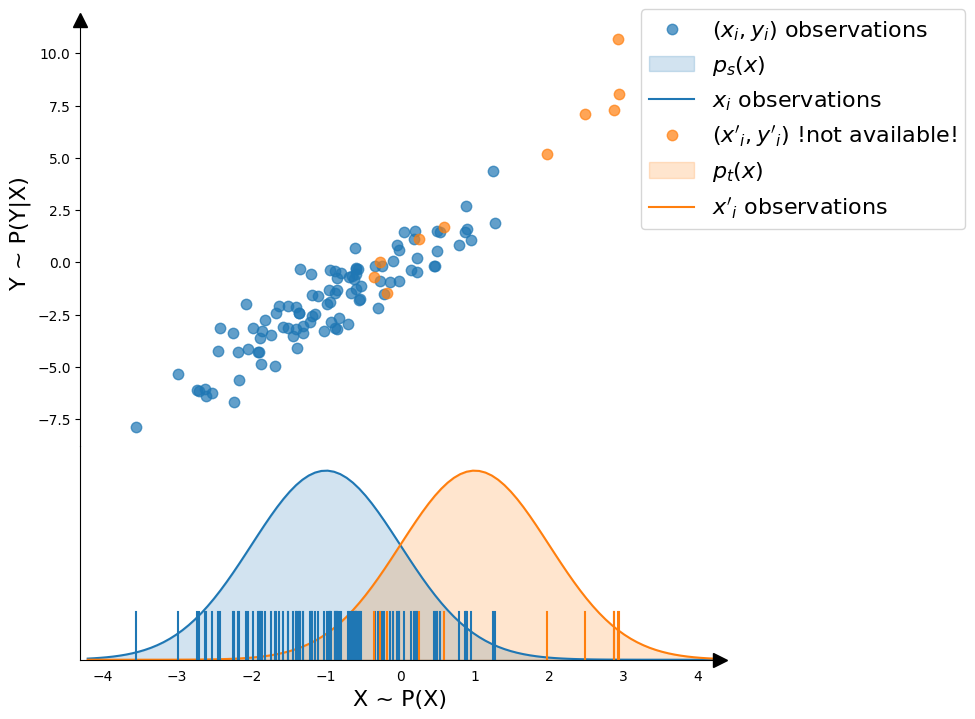

In [9]:
show_reg1d(Xs_all, Xt_all, ys_all, yt_all, mu_s=mu_s,mu_t=mu_t)

In [10]:
from sklearn.linear_model import LinearRegression
from adapt.parameter_based import RegularTransferLR


X_train_src, X_test_src, y_train_src, y_test_src = train_test_split(Xs_all, ys_all, test_size=0.5, random_state=10, shuffle=True)
X_train_tgt, X_test_tgt, y_train_tgt, y_test_tgt = train_test_split(Xt_all, yt_all, test_size=0.5, random_state=10, shuffle=True)

source_model = LinearRegression()
source_model.fit(X_train_src.reshape(-1, 1), y_train_src)

only_tgt_model = LinearRegression()
only_tgt_model.fit(X_train_tgt.reshape(-1, 1), y_train_tgt)

tr_model = RegularTransferLR(source_model, lambda_=1)
tr_model.fit(X_train_tgt.reshape(-1, 1), y_train_tgt)

print('Mean squared error : \n')
print('Source model :')
print('On source :',mse(source_model.predict(X_test_src.reshape(-1, 1)),y_test_src))
print('On target :',mse(source_model.predict(X_test_tgt.reshape(-1, 1)),y_test_tgt))

print('Target model :')
print('On source :',mse(only_tgt_model.predict(X_test_src.reshape(-1, 1)),y_test_src))
print('On target :',mse(only_tgt_model.predict(X_test_tgt.reshape(-1, 1)),y_test_tgt))

print('Transferred model :')
print('On source :',mse(tr_model.predict(X_test_src.reshape(-1, 1)),y_test_src))
print('On target :',mse(tr_model.predict(X_test_tgt.reshape(-1, 1)),y_test_tgt))

X_train_src, X_test_src, y_train_src, y_test_src = train_test_split(Xs_all, ys_all, test_size=0.5, random_state=10, shuffle=True)
X_train_tgt, X_test_tgt, y_train_tgt, y_test_tgt = train_test_split(Xt_all, yt_all, test_size=0.5, random_state=10, shuffle=True)

source_model = LinearRegression()
source_model.fit(X_train_src.reshape(-1, 1), y_train_src)

only_tgt_model = LinearRegression()
only_tgt_model.fit(X_train_tgt.reshape(-1, 1), y_train_tgt)

tr_model = RegularTransferLR(source_model, lambda_=1)
tr_model.fit(X_train_tgt.reshape(-1, 1), y_train_tgt)
print(' \n \n')


print('Mean squared error : \n')
print('Source model :')
print('On source :',mse(source_model.predict(X_test_src.reshape(-1, 1)),y_test_src))
print('On target :',mse(source_model.predict(X_test_tgt.reshape(-1, 1)),y_test_tgt))

print('Target model :')
print('On source :',mse(only_tgt_model.predict(X_test_src.reshape(-1, 1)),y_test_src))
print('On target :',mse(only_tgt_model.predict(X_test_tgt.reshape(-1, 1)),y_test_tgt))

print('Transferred model :')
print('On source :',mse(tr_model.predict(X_test_src.reshape(-1, 1)),y_test_src))
print('On target :',mse(tr_model.predict(X_test_tgt.reshape(-1, 1)),y_test_tgt))

print(' \n \n')

Mean squared error : 

Source model :
On source : 0.7940075158343555
On target : 1.6148449805113487
Target model :
On source : 1.2300051231912348
On target : 0.6564180459538317
Transferred model :
On source : 1.200000417290918
On target : 0.5929959588340973
 
 

Mean squared error : 

Source model :
On source : 0.7940075158343555
On target : 1.6148449805113487
Target model :
On source : 1.2300051231912348
On target : 0.6564180459538317
Transferred model :
On source : 1.200000417290918
On target : 0.5929959588340973
 
 



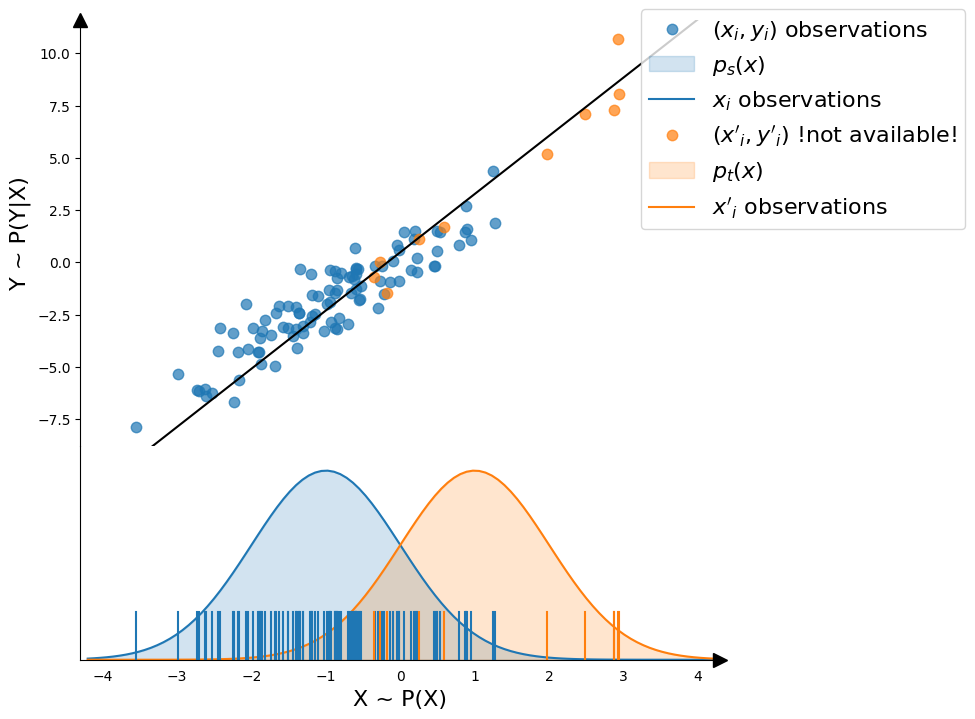

In [11]:
show_reg1d(Xs_all, Xt_all, ys_all, yt_all, model=tr_model, mu_s=mu_s,mu_t=mu_t)

#### Example 2 : pseudo-periodic regression function with uniform distribution <a name="ex2_reg"></a>

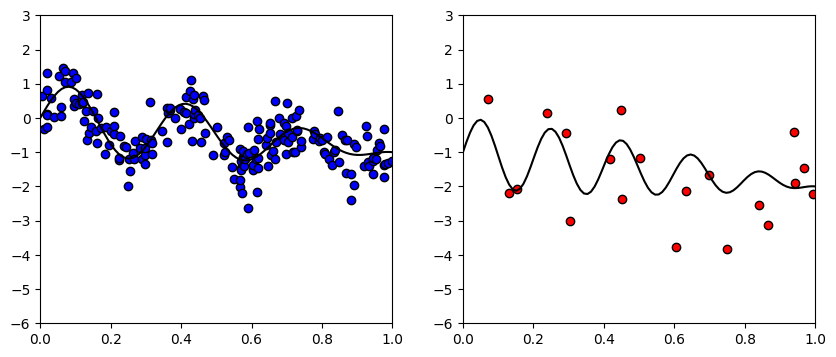

In [12]:
def label_func_sin(X,freq=2,bias=0):
    y = (1 - X**2) * np.sin(freq * 2 * np.pi * X) - X - bias
    return y

np.random.seed(0)

size_s = 200
size_t = 20

freq_s = 3
freq_t = 5

bias_s = 0
bias_t = 1
sig_s = 0.5
sig_t = 1



def fs(X):
    return label_func_sin(X,freq=freq_s,bias=bias_s)
def ft(X):
    return label_func_sin(X,freq=freq_t,bias=bias_t)

Xs_reg = np.random.rand(size_s)
Xs_reg = np.sort(Xs_reg)
Ys_reg = fs(Xs_reg) + sig_s * np.random.randn(len(Xs_reg))

Xt_reg = np.random.rand(size_t)
Xt_reg = np.sort(Xt_reg)
Yt_reg = ft(Xt_reg) + sig_t * np.random.randn(len(Xt_reg))

plot_step = 0.01
x_min, x_max = 0, 1
y_min, y_max = - 6,3

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
ax[0].scatter(Xs_reg, Ys_reg,marker='o',edgecolor='black',color='blue')
ax[1].scatter(Xt_reg, Yt_reg,marker='o',edgecolor='black',color='red')
plot_1d_func(ax[0], fs, x_min, x_max, y_min, y_max, plot_step = plot_step, title='Source data')
plot_1d_func(ax[1], ft, x_min, x_max, y_min, y_max, plot_step = plot_step, title='Target data')

In [14]:
X_train_src, X_test_src, y_train_src, y_test_src = train_test_split(Xs_reg, Ys_reg, test_size=0.5, random_state=0, shuffle=True)
X_train_tgt, X_test_tgt, y_train_tgt, y_test_tgt = train_test_split(Xt_reg, Yt_reg, test_size=0.5, random_state=0, shuffle=True)

source_model = LinearRegression()
source_model.fit(X_train_src.reshape(-1, 1), y_train_src)

only_tgt_model = LinearRegression()
only_tgt_model.fit(X_train_tgt.reshape(-1, 1), y_train_tgt)

tr_model = RegularTransferLR(source_model, lambda_=1)
tr_model.fit(X_train_tgt.reshape(-1, 1), y_train_tgt)

print('Source model error on source :',mse(source_model.predict(X_test_src.reshape(-1, 1)),y_test_src))
print('Target model error on target :',mse(only_tgt_model.predict(X_test_tgt.reshape(-1, 1)),y_test_tgt))

print('Source model error on target :',mse(source_model.predict(X_test_tgt.reshape(-1, 1)),y_test_tgt))
print('Target model error on source :',mse(only_tgt_model.predict(X_test_src.reshape(-1, 1)),y_test_src))

print('Transferred model error on source :',mse(tr_model.predict(X_test_src.reshape(-1, 1)),y_test_src))
print('Transferred model error on target :',mse(tr_model.predict(X_test_tgt.reshape(-1, 1)),y_test_tgt))

Source model error on source : 0.49757760556610864
Target model error on target : 1.8818135192199577
Source model error on target : 3.3771448016045738
Target model error on source : 0.9703165740798495
Transferred model error on source : 0.9090960403932545
Transferred model error on target : 1.8140195199891216


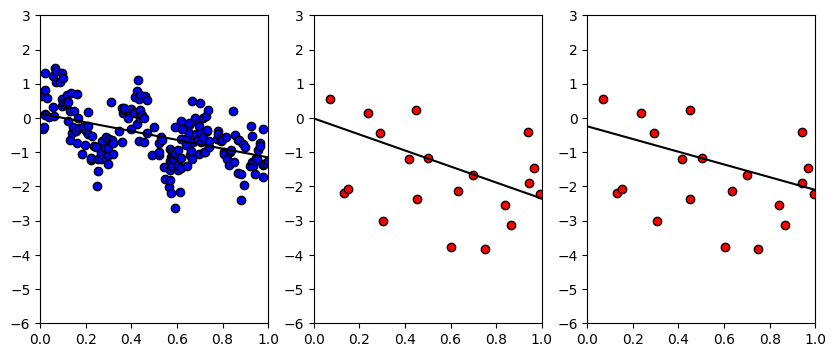

In [15]:
def pred_fs(X):
    return source_model.predict(X.reshape(-1, 1))
def pred_ft(X):
    return only_tgt_model.predict(X.reshape(-1, 1))
def pred_ftr(X):
    return tr_model.predict(X.reshape(-1, 1))

fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(10, 4))
ax[0].scatter(Xs_reg, Ys_reg,marker='o',edgecolor='black',color='blue')
ax[1].scatter(Xt_reg, Yt_reg,marker='o',edgecolor='black',color='red')
ax[2].scatter(Xt_reg, Yt_reg,marker='o',edgecolor='black',color='red')

plot_1d_func(ax[0], pred_fs, x_min, x_max, y_min, y_max, plot_step = plot_step, title='Source data')
plot_1d_func(ax[1], pred_ft, x_min, x_max, y_min, y_max, plot_step = plot_step, title='Target data')
plot_1d_func(ax[2], pred_ftr, x_min, x_max, y_min, y_max, plot_step = plot_step, title='Target data')

<h3>Supervised transfer learning for 2-d classification </h3> <a name="classif"></a>

#### Example 1 : two gaussian clusters classification <a name="ex1_classif"></a>

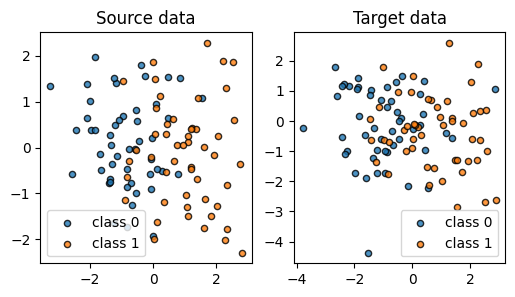

In [16]:
np.random.seed(0)

#eps_m1 = np.random.rand(2)/10
#eps_m2 = np.random.rand(2)/10

eps_m1 = 0
eps_m2 = 0

eps_var = np.random.rand()

eps_cov = 0
#eps_cov = np.random.rand()

mean_s_0 = np.array([-1,0])
mean_s_1 = np.array([1,0])

mean_t_0 = mean_s_0 + eps_m1
mean_t_1 = mean_s_1 + eps_m2


sig_s_0 = np.array([[1,0],[0,1]])
sig_s_1 = np.array([[1,0],[0,1]])
sig_t_0 = np.array([[1+eps_var,eps_cov],[eps_cov,1+eps_var]])
sig_t_1 = np.array([[1+eps_var,eps_cov],[eps_cov,1+eps_var]])

size_s=100
size_t=100

ns_0 = size_s//2
nt_0 = size_t//2

Xs_0 = np.random.multivariate_normal(mean_s_0, sig_s_0, size=ns_0)
Xs_1 = np.random.multivariate_normal(mean_s_1, sig_s_1, size=size_s-ns_0)

Xt_0 = np.random.multivariate_normal(mean_t_0, sig_t_0, size=nt_0)
Xt_1 = np.random.multivariate_normal(mean_t_1, sig_t_1, size=size_t-nt_0)

Xs = np.r_[Xs_0,Xs_1]
Xt = np.r_[Xt_0,Xt_1]

ys = np.zeros(size_s)
ys[ns_0:] = 1
yt = np.zeros(size_t)
yt[nt_0:] = 1

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(6, 3))
plot_dots(ax[0],Xs,ys, title='Source data')
plot_dots(ax[1],Xt,yt, title='Target data')

Text(0.5, 0.98, 'Target')

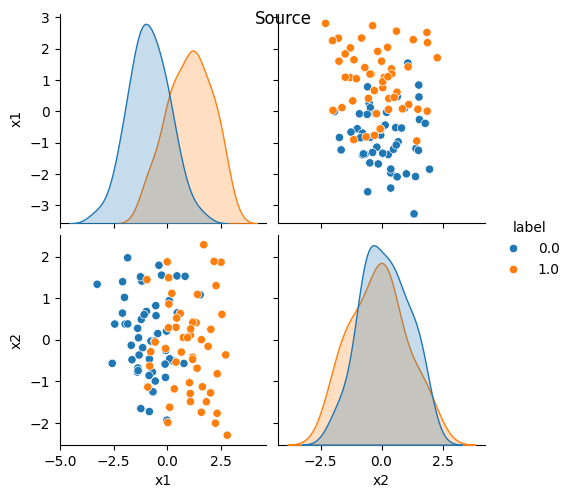

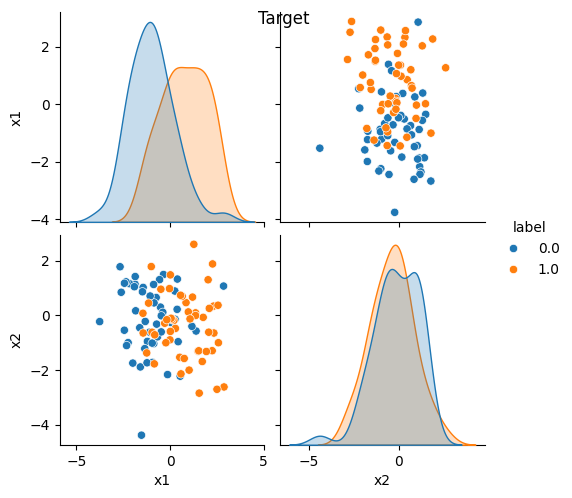

In [19]:
data_s = pd.DataFrame(columns=['x1','x2','label'])
data_s[['x1','x2']] = Xs
data_s['label'] = ys

data_t = pd.DataFrame(columns=['x1','x2','label'])
data_t[['x1','x2']] = Xt
data_t['label'] = yt

g = sns.pairplot(data_s,hue = 'label')
g.fig.suptitle('Source')
g = sns.pairplot(data_t,hue = 'label')
g.fig.suptitle('Target')

Source score on source : 0.8
Source score on target : 0.7368421052631579


Text(0.5, 0.98, 'Source model')

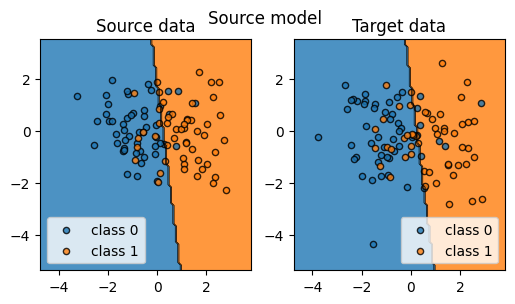

In [20]:
from sklearn.linear_model import SGDClassifier
from adapt.parameter_based import RegularTransferLC

X_train_src, X_test_src, y_train_src, y_test_src = train_test_split(Xs, ys, test_size=0.5, random_state=0, shuffle=True)

#Reducing Target training data this way :
X_train_tgt, X_test_tgt, y_train_tgt, y_test_tgt = train_test_split(Xt, yt, test_size=0.95, random_state=0, shuffle=True)

source_model = SGDClassifier()
source_model.fit(X_train_src,y_train_src)

only_tgt_model = SGDClassifier()
only_tgt_model.fit(X_train_tgt,y_train_tgt)

print('Source score on source :',source_model.score(X_test_src,y_test_src))
print('Source score on target :',source_model.score(X_test_tgt,y_test_tgt))

#This code plots the Source decision function on Source and Target data

plot_step = 0.1
x_min, x_max = Xt[:, 0].min() - 1, Xt[:, 0].max() + 1
y_min, y_max = Xt[:, 1].min() - 1, Xt[:, 1].max() + 1

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(6, 3))

plot_dec_func(ax[0], source_model, x_min, x_max, y_min, y_max, plot_step = plot_step, title='Source data',nc=1)
plot_dec_func(ax[1], source_model, x_min, x_max, y_min, y_max, plot_step = plot_step, title='Target data',nc=1)

plot_dots(ax[0],Xs,ys, title='Source data')
plot_dots(ax[1],Xt,yt, title='Target data')

fig.suptitle('Source model')

In [21]:
tr_model = RegularTransferLC(source_model, lambda_=0.2)
tr_model.fit(X_train_tgt,y_train_tgt)

print('Source model score on source :',source_model.score(X_test_src,y_test_src))
print('Target model score on target :',only_tgt_model.score(X_test_tgt,y_test_tgt))

print('Source model score on target :',source_model.score(X_test_tgt,y_test_tgt))
print('Target model score on source :',only_tgt_model.score(X_test_src,y_test_src))

print('Transferred model score on source :',tr_model.score(X_test_src,y_test_src))
print('Transferred model score on target :',tr_model.score(X_test_tgt,y_test_tgt))

(5, 1)
Source model score on source : 0.8
Target model score on target : 0.7263157894736842
Source model score on target : 0.7368421052631579
Target model score on source : 0.74
Transferred model score on source : 0.74
Transferred model score on target : 0.7684210526315789


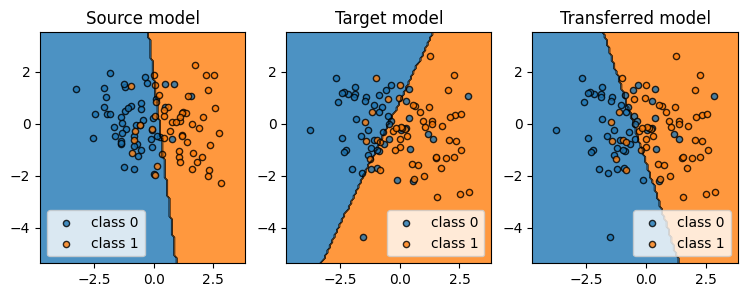

In [22]:
#This code plots the Source decision function on Source and Target data

plot_step = 0.1
x_min, x_max = Xt[:, 0].min() - 1, Xt[:, 0].max() + 1
y_min, y_max = Xt[:, 1].min() - 1, Xt[:, 1].max() + 1

fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(9, 3))

plot_dec_func(ax[0], source_model,  x_min, x_max, y_min, y_max, plot_step = plot_step, title='Source model',nc=1)
plot_dec_func(ax[1], only_tgt_model, x_min, x_max, y_min, y_max, plot_step = plot_step, title='Target model',nc=1)
plot_dec_func(ax[2], tr_model, x_min, x_max, y_min, y_max, plot_step = plot_step, title='Transferred model',nc=1)

plot_dots(ax[0],Xs,ys, title='Source model')
plot_dots(ax[1],Xt,yt, title='Target model')
plot_dots(ax[2],Xt,yt, title='Transferred model')

#### Example 2 : pseudo-periodic classification <a name="ex2_classif"></a>

In [23]:
def label_func_sin(X,freq=2,bias=0):
    y = (1 - X**2) * np.sin(freq * 2 * np.pi * X) - X - bias
    return y

np.random.seed(0)

size_s = 200
size_t = 200

freq_s = 3
freq_t = 3

bias_s = 0
bias_t = 1.5
sig_s = 0.5
sig_t = 0.5

p_noise = 0.95

label_noise_s = np.random.rand(size_s)
label_noise_t = np.random.rand(size_t)

def fs(X):
    return label_func_sin(X,freq=freq_s,bias=bias_s)
def ft(X):
    return label_func_sin(X,freq=freq_t,bias=bias_t)


Xs = np.zeros((size_s,2))
Xt = np.zeros((size_t,2))

Xs_ = np.random.rand(size_s)
Xs_ = np.sort(Xs_)

Xt_ = np.random.rand(size_t)
Xt_ = np.sort(Xt_)

Xs[:,0] = Xs_
Xs[:,1] = fs(Xs_) + sig_s * np.random.randn(len(Xs_))

#Deterministic case:
#ys = Xs[:,1] > fs(Xs_)

ys = (Xs[:,1] > fs(Xs_))*(label_noise_s<p_noise) + (Xs[:,1] < fs(Xs_))*(label_noise_s>p_noise)

Xt[:,0] = Xt_
Xt[:,1] = ft(Xt_) + sig_t * np.random.randn(len(Xt_))

#Deterministic case:
#yt = Xt[:,1] > ft(Xt_)

yt = (Xt[:,1] > ft(Xt_))*(label_noise_t<p_noise) + (Xt[:,1] < ft(Xt_))*(label_noise_t>p_noise )

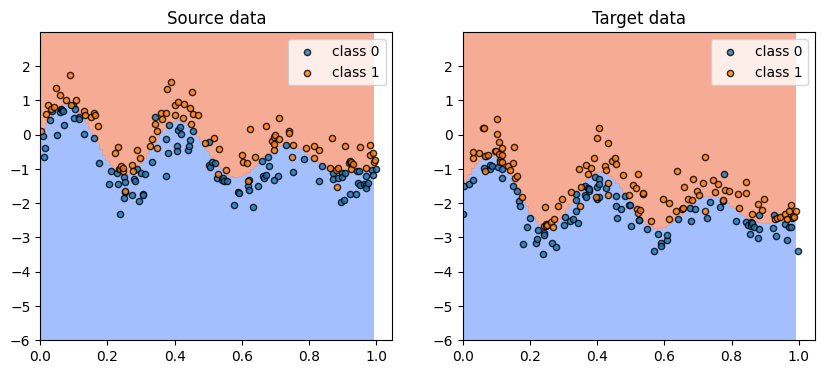

In [24]:
plot_step = 0.01
x_min, x_max = 0, 1
y_min, y_max = - 6,3

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))


plot_dec_func_explicite(ax[0], fs, x_min, x_max, y_min, y_max, plot_step=plot_step, title='Source data')
plot_dec_func_explicite(ax[1], ft, x_min, x_max, y_min, y_max, plot_step=plot_step, title='Target data')

plot_dots(ax[0],Xs,ys, title='Source data')
plot_dots(ax[1],Xt,yt, title='Target data')

In [25]:
np.random.seed(0)
source_model = SGDClassifier()
source_model.fit(Xs, ys)

only_tgt_model = SGDClassifier()
only_tgt_model.fit(Xt, yt)

tr_model = RegularTransferLC(source_model, lambda_=0.1)
tr_model.fit(Xt, yt)


print('Source model score on source :',source_model.score(Xs,ys))
print('Target model score on target :',only_tgt_model.score(Xt,yt))

print('Source model score on target :',source_model.score(Xt,yt))
print('Target model score on source :',only_tgt_model.score(Xs,ys))

print('Transferred model score on source :',tr_model.score(Xs,ys))
print('Transferred model score on target :',tr_model.score(Xt,yt))

(200, 1)
Source model score on source : 0.695
Target model score on target : 0.565
Source model score on target : 0.51
Target model score on source : 0.475
Transferred model score on source : 0.505
Transferred model score on target : 0.755


Text(0.5, 0.98, 'Source model')

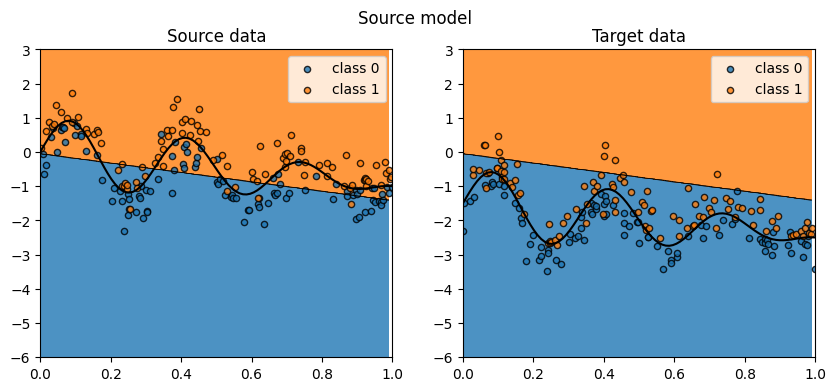

In [26]:
plot_step = 0.01
x_min, x_max = 0, 1
y_min, y_max = - 6,3

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))

plot_1d_func(ax[0], fs, x_min, x_max, y_min, y_max, plot_step = plot_step, title='Source data')
plot_1d_func(ax[1], ft, x_min, x_max, y_min, y_max, plot_step = plot_step, title='Target data')


plot_dec_func(ax[0], source_model,  x_min, x_max, y_min, y_max, plot_step = plot_step, title='Source data',nc=1)
plot_dec_func(ax[1], source_model, x_min, x_max, y_min, y_max, plot_step = plot_step, title='Target data',nc=1)

plot_dots(ax[0],Xs,ys, title='Source data')
plot_dots(ax[1],Xt,yt, title='Target data')

fig.suptitle('Source model')

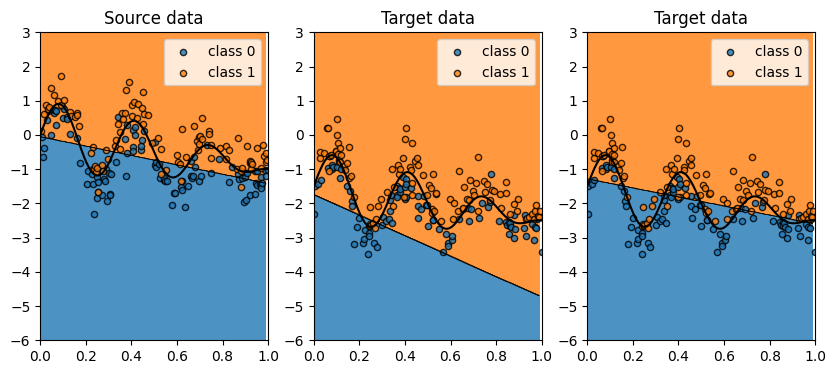

In [27]:
plot_step = 0.01
x_min, x_max = 0, 1
y_min, y_max = - 6,3

fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(10, 4))

plot_1d_func(ax[0], fs, x_min, x_max, y_min, y_max, plot_step = plot_step, title='Source data')
plot_1d_func(ax[1], ft, x_min, x_max, y_min, y_max, plot_step = plot_step, title='Target data')
plot_1d_func(ax[2], ft, x_min, x_max, y_min, y_max, plot_step = plot_step, title='Target data')

plot_dec_func(ax[0], source_model,  x_min, x_max, y_min, y_max, plot_step = plot_step, title='Source model',nc=1)
plot_dec_func(ax[1], only_tgt_model, x_min, x_max, y_min, y_max, plot_step = plot_step, title='Target model',nc=1)
plot_dec_func(ax[2], tr_model, x_min, x_max, y_min, y_max, plot_step = plot_step, title='Transferred model',nc=1)

plot_dots(ax[0],Xs,ys, title='Source data')
plot_dots(ax[1],Xt,yt, title='Target data')
plot_dots(ax[2],Xt,yt, title='Target data')

<h2>Supervised transfer learning on decision tree based models </h2><a name="dt"></a>

<h3>Example 1 : decision tree for pseudo-periodic classification</h3><a name="dt_sin"></a>

In [28]:
from skada import source_target_split
from skada.datasets import make_shifted_datasets
import adapt._tree_utils as ut
from adapt.parameter_based import TransferTreeClassifier, TransferForestClassifier
from adapt.parameter_based  import TransferTreeSelector, TransferForestSelector

In [29]:
np.random.seed(0)

def label_func_sin(X,freq=2,bias=0):
    y = (1 - X**2) * np.sin(freq * 2 * np.pi * X) - X - bias
    return y

size_s = 100
size_t = 100

freq_s = 3
freq_t = 3

bias_s = 0
bias_t = 1.5
sig_s = 0.5
sig_t = 0.5

p_noise = 0.95

label_noise_s = np.random.rand(size_s)
label_noise_t = np.random.rand(size_t)

def fs(X):
    return label_func_sin(X,freq=freq_s,bias=bias_s)
def ft(X):
    return label_func_sin(X,freq=freq_t,bias=bias_t)


Xs = np.zeros((size_s,2))
Xt = np.zeros((size_t,2))

Xs_ = np.random.rand(size_s)
Xs_ = np.sort(Xs_)

Xt_ = np.random.rand(size_t)
Xt_ = np.sort(Xt_)

Xs[:,0] = Xs_
Xs[:,1] = fs(Xs_) + sig_s * np.random.randn(len(Xs_))

ys = (Xs[:,1] > fs(Xs_))*(label_noise_s<p_noise) + (Xs[:,1] < fs(Xs_))*(label_noise_s>p_noise)

Xt[:,0] = Xt_
Xt[:,1] = ft(Xt_) + sig_t * np.random.randn(len(Xt_))

yt = (Xt[:,1] > ft(Xt_))*(label_noise_t<p_noise) + (Xt[:,1] < ft(Xt_))*(label_noise_t>p_noise )

In [30]:
MAX = 5
K_FOLD = 10
N_EST = 10

# For a unique decision tree
DT_only = True

# Source and Target classifiers :
if DT_only:
    clf_source = DecisionTreeClassifier(max_depth=MAX)
    clf_target = DecisionTreeClassifier(max_depth=MAX)
else:
    clf_source = RandomForestClassifier(n_estimators=N_EST,max_depth=MAX)
    clf_target = RandomForestClassifier(n_estimators=N_EST,max_depth=MAX)

#K folds coss-validation:
skf = select.StratifiedKFold(n_splits=K_FOLD,shuffle= True)

score_src = np.zeros(K_FOLD)
score_src_tgt = np.zeros(K_FOLD)
score_tgt_src = np.zeros(K_FOLD)
score_tgt = np.zeros(K_FOLD)

k=0
for train, test in skf.split(Xs, ys):
    X_src_train, Y_src_train, X_src_test, Y_src_test = Xs[train], ys[train], Xs[test], ys[test]
    clf_source.fit(X_src_train, Y_src_train)
    score_src[k] = clf_source.score(X_src_test, Y_src_test)
    score_src_tgt[k] = clf_source.score(Xt, yt)

    k+=1


#K folds coss-validation:
skf = select.StratifiedKFold(n_splits=K_FOLD,shuffle= True)

k=0
for test, train in skf.split(Xt, yt):
    X_tgt_train, Y_tgt_train, X_tgt_test, Y_tgt_test = Xt[train], yt[train], Xt[test], yt[test]
    clf_target.fit(X_tgt_train, Y_tgt_train)
    score_tgt[k] = clf_target.score(X_tgt_test, Y_tgt_test)
    score_tgt_src[k] = clf_target.score(Xs, ys)

    k+=1

print('Score Target model: {:.3f}'.format(np.mean(score_tgt)))
print('Score Source model: {:.3f}'.format(np.mean(score_src)))
print('Score Source model on Target: {:.3f}'.format(np.mean(score_src_tgt)))
#print('Score Target model on Source: {:.3f}'.format(np.mean(score_tgt_src)))

Score Target model: 0.609
Score Source model: 0.830
Score Source model on Target: 0.504


In [31]:
skf = select.StratifiedKFold(n_splits=K_FOLD,shuffle= True)

clf_src = copy.deepcopy(clf_source)

methods = [
    'ser',
    'strut'
]
labels = [
    '$SER$',
    '$STRUT$'
]

mean_strut = 0
mean_ser = 0

mean_auc_strut = 0
mean_auc_ser = 0

for train, test in skf.split(Xt, yt):
    X_tgt_train, Y_tgt_train, X_tgt_test, Y_tgt_test = Xt[train], yt[train], Xt[test], yt[test]

    clfs = []
    scores = []
    auc_scores = []

    for m,method in enumerate(methods):

        clf_transfer = copy.deepcopy(clf_source)

        if method == 'ser':
            if DT_only:
                transferred_model = TransferTreeClassifier(estimator=clf_transfer,algo="ser")
            else:
                transferred_model = TransferForestClassifier(estimator=clf_transfer,algo="ser")
            transferred_model.fit(X_tgt_train,Y_tgt_train)
            clf_ser = copy.deepcopy(transferred_model.estimator_)

        if method == 'strut':
            if DT_only:
                transferred_model = TransferTreeClassifier(estimator=clf_transfer,algo="strut")
            else:
                transferred_model = TransferForestClassifier(estimator=clf_transfer,algo="strut")
            transferred_model.fit(X_tgt_train,Y_tgt_train)
            clf_strut = copy.deepcopy(transferred_model.estimator_)


        score = transferred_model.estimator_.score(X_tgt_test, Y_tgt_test)
        yp = transferred_model.estimator_.predict_proba(X_tgt_test)[:,1]
        auc_score = roc_auc_score(Y_tgt_test,yp)

        #print('Testing score transferred model ({}) : {:.3f}'.format(method, score))
        #print('Testing ROC AUC score transferred model ({}) : {:.3f}'.format(method, auc_score))

        clfs.append(transferred_model.estimator_)
        scores.append(np.copy(score))
        auc_scores.append(auc_score)


    mean_ser += scores[0]
    mean_strut += scores[1]

    mean_auc_ser += auc_scores[0]
    mean_auc_strut += auc_scores[1]


mean_ser /= K_FOLD
mean_strut /= K_FOLD

mean_auc_ser /= K_FOLD
mean_auc_strut /= K_FOLD

print('SCORE SER :',mean_ser)
print('SCORE STRUT :',mean_strut)

print('AUC SCORE SER :',mean_auc_ser)
print('AUC SCORE STRUT :',mean_auc_strut)

SCORE SER : 0.75
SCORE STRUT : 0.63
AUC SCORE SER : 0.76325
AUC SCORE STRUT : 0.6673333333333333


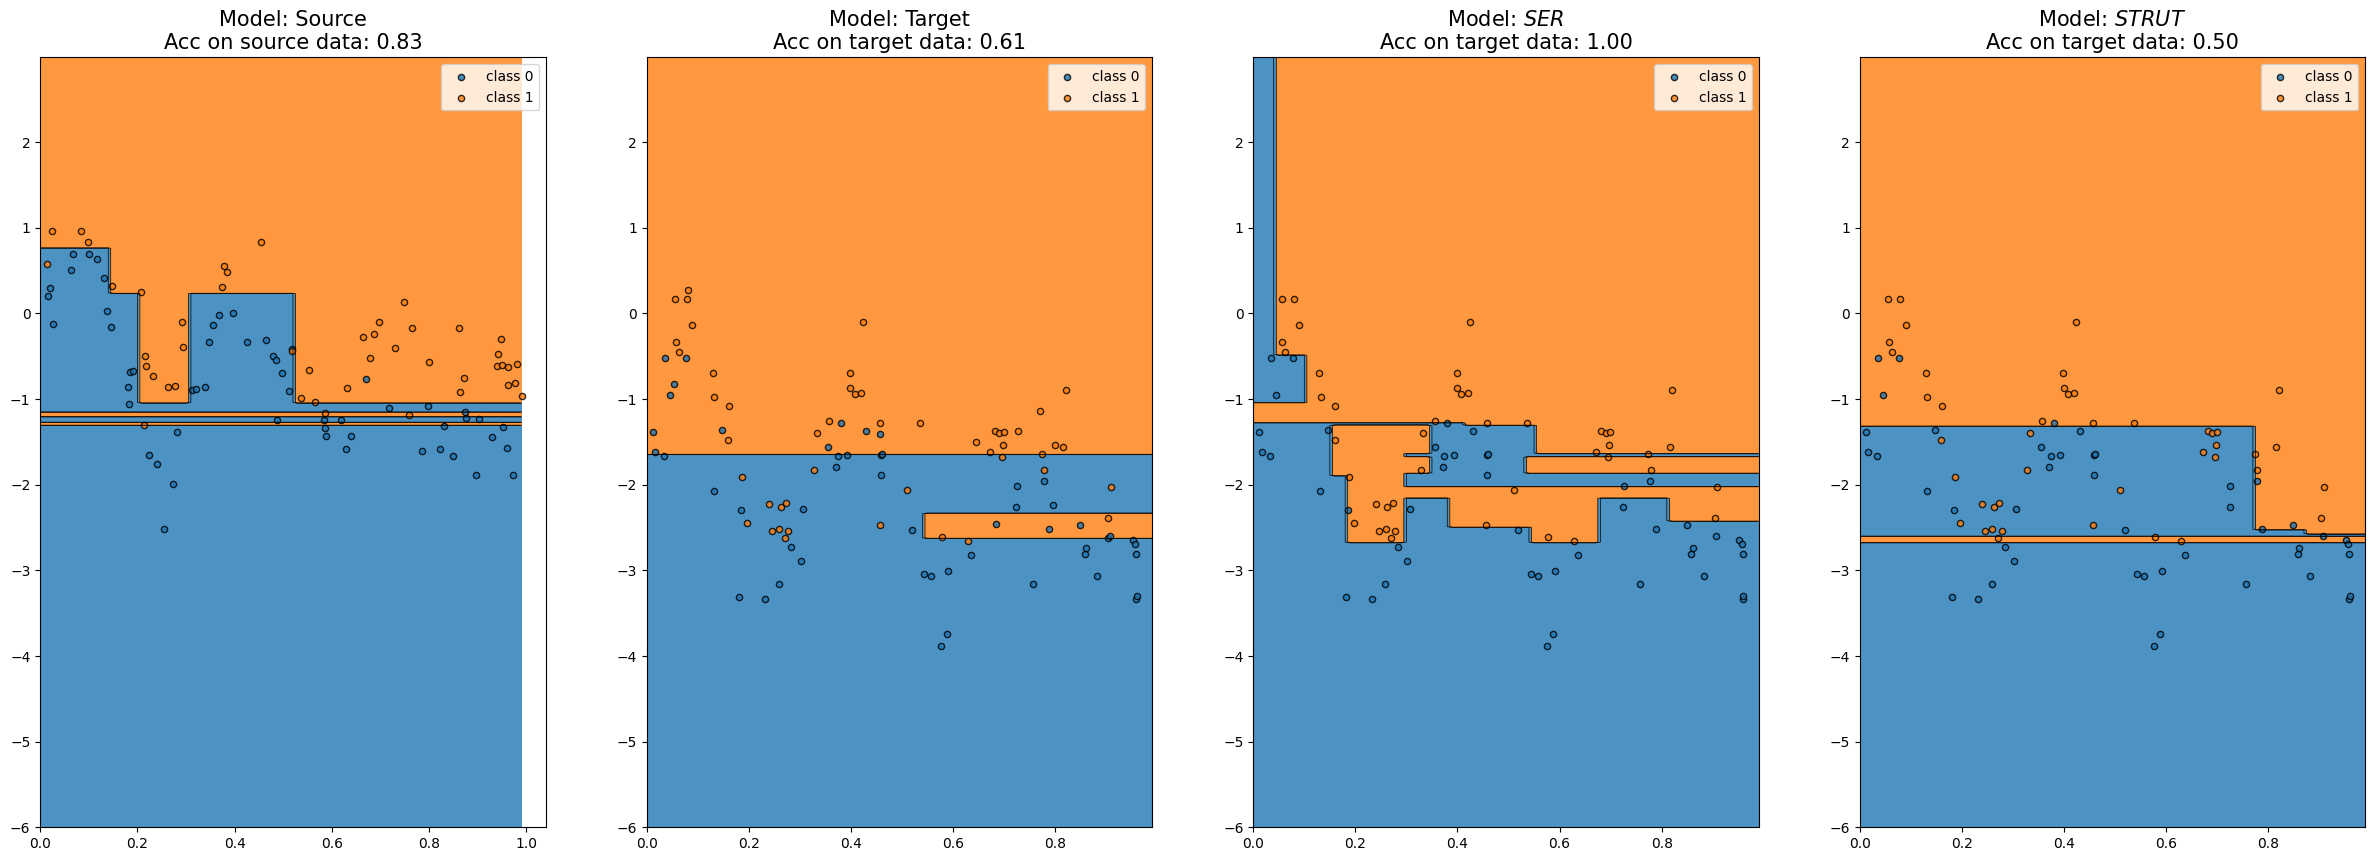

In [32]:
# Plot decision functions

plot_step = 0.01

fig, ax = plt.subplots(nrows=1, ncols=len(methods) + 2, figsize=(30, 10))


plot_dec_func(ax[0], clf_source,  x_min = 0, x_max = 1, y_min = -6, y_max = 3, plot_step = plot_step, title='Source model',nc=1)
plot_dots(ax[0],Xs,ys, title='Source data')
ax[0].set_title('Model: Source\nAcc on source data: {:.2f}'.format(np.mean(score_src)),
                fontsize=15)

plot_dec_func(ax[1], clf_target,  x_min = 0, x_max = 1, y_min = -6, y_max = 3, plot_step = plot_step, title='Target model',nc=1)
plot_dots(ax[1],Xt,yt, title='Target data')
ax[1].set_title('Model: Target\nAcc on target data: {:.2f}'.format(np.mean(score_tgt)),
                fontsize=15)


# Plot transfer models
for i, (method, label, score) in enumerate(zip(methods, labels, scores)):
    clf_transfer = clfs[i]

    plot_dec_func(ax[i+2], clf_transfer, x_min = 0, x_max = 1, y_min = -6, y_max = 3, plot_step = plot_step, title=label,nc=1)
    plot_dots(ax[i+2],X_tgt_train,Y_tgt_train, title=label)
    ax[i + 2].set_title('Model: {}\nAcc on target data: {:.2f}'.format(label, score),
                        fontsize=15)

plt.show()

In [33]:
from skada.datasets import make_dataset_from_moons_distribution
from skada import source_target_split
from skada.datasets import make_shifted_datasets

np.random.seed(0)

target_marker = "*"
source_marker = "o"
xlim = (-1.5, 2.5)
ylim = (-1.5, 1.5)

X, y, sample_domain = make_dataset_from_moons_distribution(
    pos_source=[ 0.25,0.5,0.6, 0.2, 0.1],
    pos_target=[ 0.2, 0.5,0.7,0.9,0.95],
    n_samples_source=10,
    n_samples_target=10,
    noise=0.2,
    random_state=0,
)

X_source, X_target, y_source, y_target = source_target_split(X, y, sample_domain=sample_domain)

Text(0.5, 1.0, 'Target data')

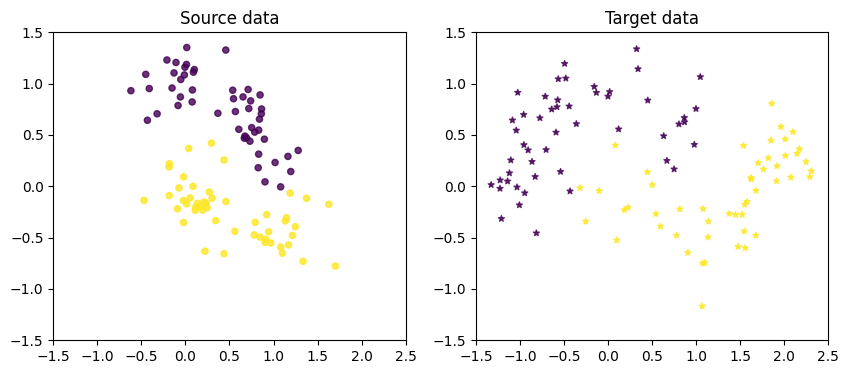

In [34]:
figure, axis = plt.subplots(1, 2, figsize=(10, 4))

axis[0].scatter(X_source[:, 0], X_source[:, 1], c=y_source, marker=source_marker,alpha=0.8,s=20)
axis[0].set_xlim(xlim)
axis[0].set_ylim(ylim)
axis[0].set_title("Source data")

axis[1].scatter(X_target[:, 0], X_target[:, 1], c=y_target, marker=target_marker,alpha=0.8,s=20)
axis[1].set_xlim(xlim)
axis[1].set_ylim(ylim)
axis[1].set_title("Target data")

In [35]:
Xs, ys = X_source,y_source
Xt, yt = X_target,y_target


MAX = None
K_FOLD = 5
N_EST = 5

# False for a Random Forest
DT_only = False

# Source and Target classifiers :
if DT_only:
    clf_source = DecisionTreeClassifier(max_depth=MAX)
    clf_target = DecisionTreeClassifier(max_depth=MAX)
else:
    clf_source = RandomForestClassifier(n_estimators=N_EST,max_depth=MAX)
    clf_target = RandomForestClassifier(n_estimators=N_EST,max_depth=MAX)

#K folds coss-validation:
skf = select.StratifiedKFold(n_splits=K_FOLD,shuffle=True)

score_src = np.zeros(K_FOLD)
score_src_tgt = np.zeros(K_FOLD)

auc_score_src = np.zeros(K_FOLD)
auc_score_src_tgt = np.zeros(K_FOLD)


k=0
for train, test in skf.split(Xs, ys):
    X_src_train, Y_src_train, X_src_test, Y_src_test = Xs[train], ys[train], Xs[test], ys[test]
    clf_source.fit(X_src_train, Y_src_train)
    score_src[k] = clf_source.score(X_src_test, Y_src_test)
    score_src_tgt[k] = clf_source.score(Xt, yt)

    yp = clf_source.predict_proba(X_src_test)[:,1]
    ypt = clf_source.predict_proba(Xt)[:,1]

    auc_score_src[k] = roc_auc_score(Y_src_test,yp)
    auc_score_src_tgt[k] = roc_auc_score(yt,ypt)

    k+=1



## WARNING : Here 'train' and 'test' indexes are artificially inverted just to get fewer training data in target.
#K folds coss-validation:

score_tgt_src = np.zeros(K_FOLD)
score_tgt = np.zeros(K_FOLD)

auc_score_tgt = np.zeros(K_FOLD)
auc_score_tgt_src = np.zeros(K_FOLD)

skf = select.StratifiedKFold(n_splits=K_FOLD,shuffle=True)
k=0
for test, train in skf.split(Xt, yt):

    X_tgt_train, Y_tgt_train, X_tgt_test, Y_tgt_test = Xt[train], yt[train], Xt[test], yt[test]
    clf_target.fit(X_tgt_train, Y_tgt_train)
    score_tgt[k] = clf_target.score(X_tgt_test, Y_tgt_test)
    score_tgt_src[k] = clf_target.score(Xs, ys)

    yp = clf_target.predict_proba(X_tgt_test)[:,1]
    yps = clf_target.predict_proba(Xs)[:,1]

    auc_score_tgt[k] = roc_auc_score(Y_tgt_test,yp)
    auc_score_tgt_src[k] = roc_auc_score(ys,yps)

    k+=1


print('n° Target training data : ', train.size)
print('n° Target testing data : ', test.size)

print('Score Target model: {:.3f}'.format(np.mean(score_tgt)))
print('Score Source model: {:.3f}'.format(np.mean(score_src)))
print('Score Source model on Target: {:.3f}'.format(np.mean(score_src_tgt)))
#print('Score Target model on Source: {:.3f}'.format(np.mean(score_tgt_src)))


print('AUC score Target model: {:.3f}'.format(np.mean(auc_score_tgt)))
print('AUC score Source model: {:.3f}'.format(np.mean(auc_score_src)))
print('AUC score Source model on Target: {:.3f}'.format(np.mean(auc_score_src_tgt)))
#print('Score Target model on Source: {:.3f}'.format(np.mean(score_tgt_src)))

n° Target training data :  20
n° Target testing data :  80
Score Target model: 0.857
Score Source model: 0.930
Score Source model on Target: 0.646
AUC score Target model: 0.916
AUC score Source model: 0.969
AUC score Source model on Target: 0.698


In [36]:
clf_src = copy.deepcopy(clf_source)

methods = [
    'ser',
    'strut'
]
labels = [
    '$SER$',
    '$STRUT$'
]

mean_strut = 0
mean_ser = 0

mean_auc_strut = 0
mean_auc_ser = 0

for test, train in skf.split(Xt, yt):
    X_tgt_train, Y_tgt_train, X_tgt_test, Y_tgt_test = Xt[train], yt[train], Xt[test], yt[test]

    clfs = []
    scores = []
    auc_scores = []

    for m,method in enumerate(methods):

        clf_transfer = copy.deepcopy(clf_source)

        if method == 'ser':
            if DT_only:
                transferred_model = TransferTreeClassifier(estimator=clf_transfer,algo="ser")
            else:
                transferred_model = TransferForestClassifier(estimator=clf_transfer,algo="ser")
            transferred_model.fit(X_tgt_train,Y_tgt_train)
            clf_ser = copy.deepcopy(transferred_model.estimator_)

        if method == 'strut':
            if DT_only:
                transferred_model = TransferTreeClassifier(estimator=clf_transfer,algo="strut")
            else:
                transferred_model = TransferForestClassifier(estimator=clf_transfer,algo="strut")
            transferred_model.fit(X_tgt_train,Y_tgt_train)
            clf_strut = copy.deepcopy(transferred_model.estimator_)


        score = transferred_model.estimator_.score(X_tgt_test, Y_tgt_test)
        yp = transferred_model.estimator_.predict_proba(X_tgt_test)[:,1]
        auc_score = roc_auc_score(Y_tgt_test,yp)

        #print('Testing score transferred model ({}) : {:.3f}'.format(method, score))
        #print('Testing ROC AUC score transferred model ({}) : {:.3f}'.format(method, auc_score))

        clfs.append(transferred_model.estimator_)
        scores.append(np.copy(score))
        auc_scores.append(auc_score)

    mean_ser += scores[0]
    mean_strut += scores[1]

    mean_auc_ser += auc_scores[0]
    mean_auc_strut += auc_scores[1]

mean_ser /= K_FOLD
mean_strut /= K_FOLD

mean_auc_ser /= K_FOLD
mean_auc_strut /= K_FOLD

print('SCORE SER :',mean_ser)
print('SCORE STRUT :',mean_strut)

print('AUC SCORE SER :',mean_auc_ser)
print('AUC SCORE STRUT :',mean_auc_strut)

SCORE SER : 0.9075
SCORE STRUT : 0.8399999999999999
AUC SCORE SER : 0.983375
AUC SCORE STRUT : 0.9274374999999999


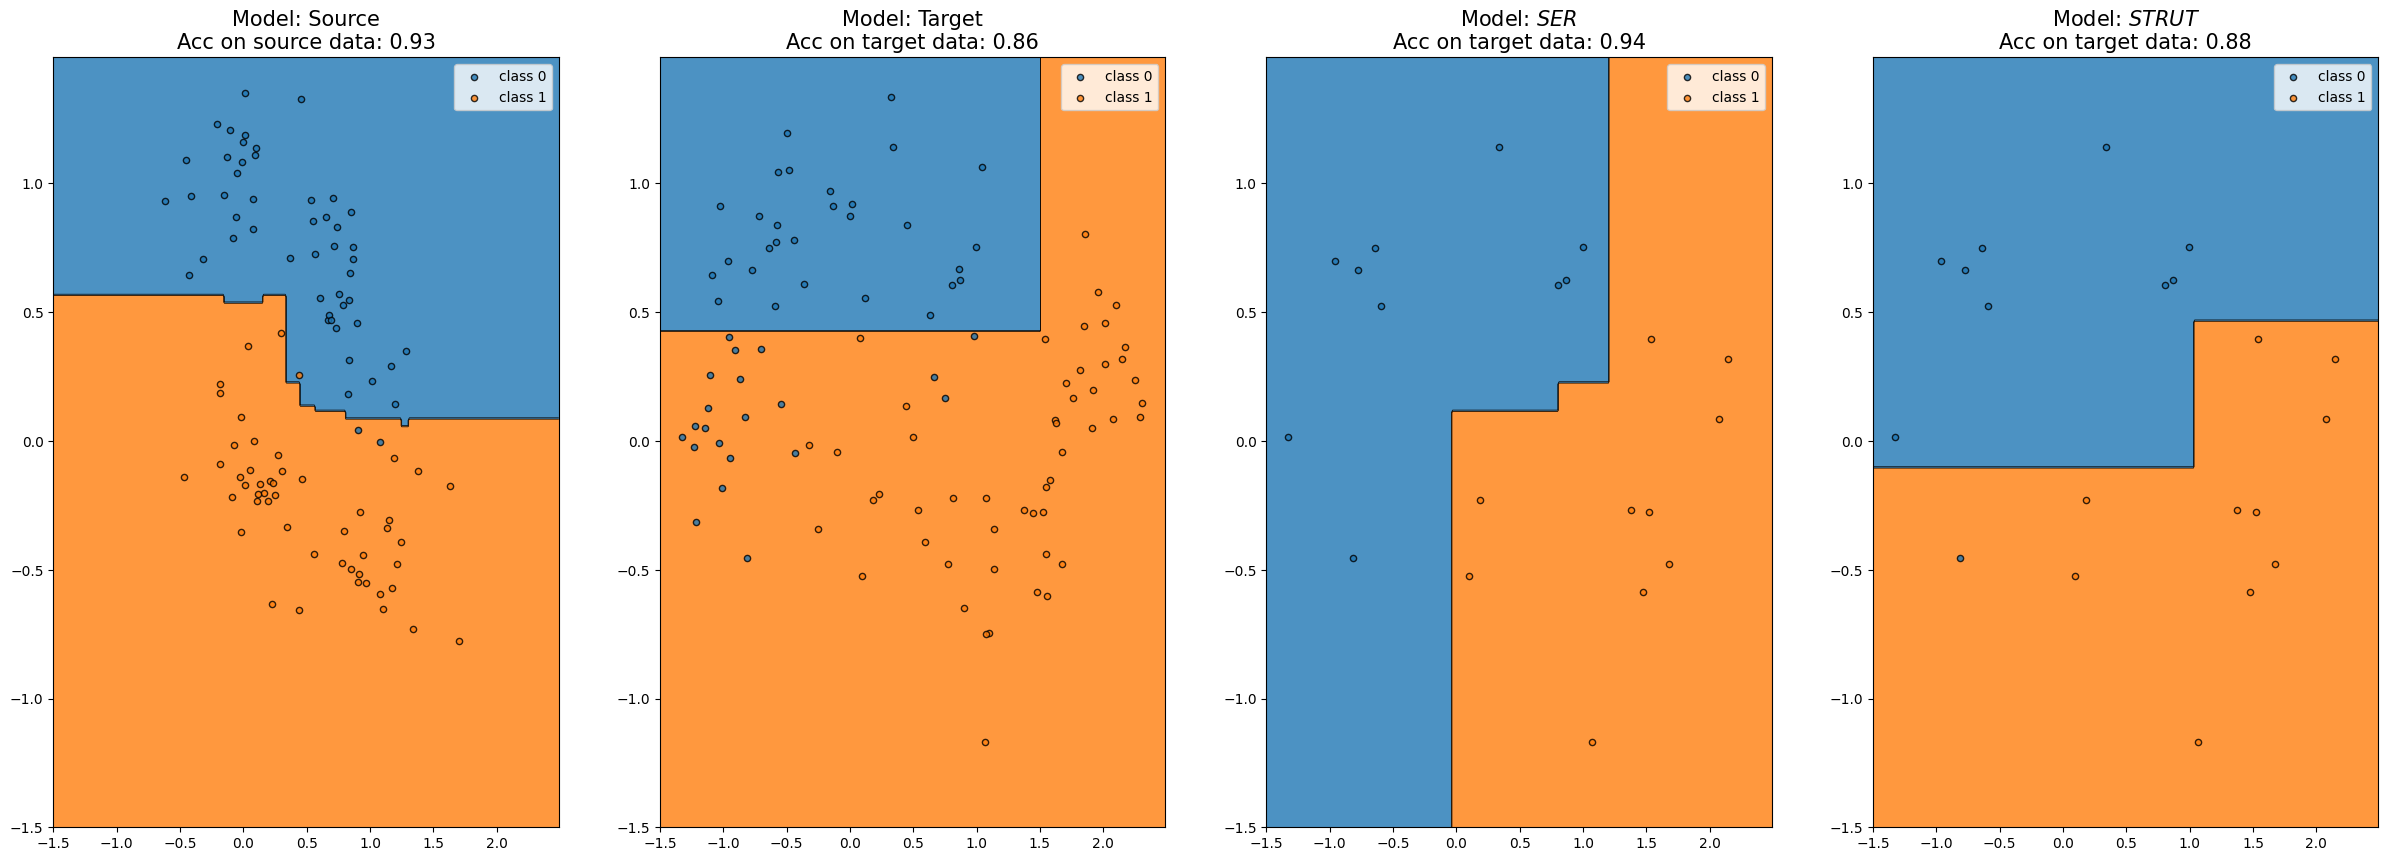

In [37]:
# Plot decision functions

plot_step = 0.01

fig, ax = plt.subplots(nrows=1, ncols=len(methods) + 2, figsize=(30, 10))


plot_dec_func(ax[0], clf_source,  x_min = xlim[0], x_max = xlim[1], y_min = ylim[0], y_max = ylim[1], plot_step = plot_step, title='Source model',nc=1)
plot_dots(ax[0],Xs,ys, title='Source data')
ax[0].set_title('Model: Source\nAcc on source data: {:.2f}'.format(np.mean(score_src)),
                fontsize=15)

plot_dec_func(ax[1], clf_target,  x_min = xlim[0], x_max = xlim[1], y_min = ylim[0], y_max = ylim[1], plot_step = plot_step, title='Target model',nc=1)
plot_dots(ax[1],Xt,yt, title='Target data')
ax[1].set_title('Model: Target\nAcc on target data: {:.2f}'.format(np.mean(score_tgt)),
                fontsize=15)


# Plot transfer models
for i, (method, label, score) in enumerate(zip(methods, labels, scores)):
    clf_transfer = clfs[i]

    plot_dec_func(ax[i+2], clf_transfer, x_min = xlim[0], x_max = xlim[1], y_min = ylim[0], y_max = ylim[1], plot_step = plot_step, title=label,nc=1)
    plot_dots(ax[i+2],X_tgt_train,Y_tgt_train, title=label)
    ax[i + 2].set_title('Model: {}\nAcc on target data: {:.2f}'.format(label, score),
                        fontsize=15)

plt.show()

In [38]:
from sklearn.datasets import make_moons

def make_moons_da(n_samples=200, rotation=30, noise=0.05, random_state=0):
    Xs, ys = make_moons(n_samples=n_samples,
                        noise=noise,
                        random_state=random_state)
    Xs[:, 0] -= 0.5
    theta = np.radians(-rotation)
    cos_theta, sin_theta = np.cos(theta), np.sin(theta)
    rot_matrix = np.array(
        ((cos_theta, -sin_theta),
         (sin_theta, cos_theta))
    )
    Xt = Xs.dot(rot_matrix)
    yt = ys
    return Xs, ys, Xt, yt

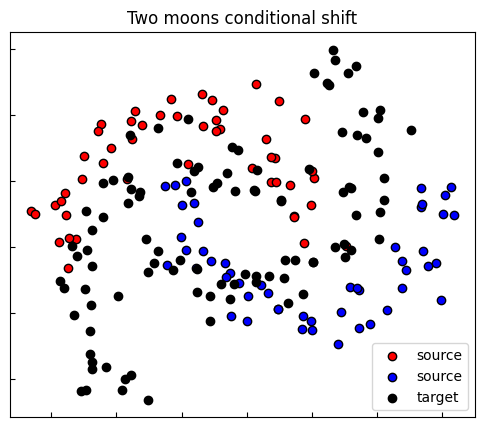

In [39]:
Xs, ys, Xt, yt = make_moons_da(n_samples=100, rotation=50, noise = 0.15)

x_min, y_min = np.min([Xs.min(0), Xt.min(0)], 0)
x_max, y_max = np.max([Xs.max(0), Xt.max(0)], 0)
x_grid, y_grid = np.meshgrid(np.linspace(x_min-0.1, x_max+0.1, 100),
                             np.linspace(y_min-0.1, y_max+0.1, 100))
X_grid = np.stack([x_grid.ravel(), y_grid.ravel()], -1)

fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))
ax1.set_title("Two moons conditional shift")
ax1.scatter(Xs[ys==0, 0], Xs[ys==0, 1], label="source", edgecolors='k', c="red")
ax1.scatter(Xs[ys==1, 0], Xs[ys==1, 1], label="source", edgecolors='k', c="blue")
ax1.scatter(Xt[:, 0], Xt[:, 1], label="target", edgecolors='k', c="black")
ax1.legend(loc="lower right")
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.tick_params(direction ='in')
plt.show()

In [40]:
MAX = None
K_FOLD = 5
N_EST = 10
DT_only = False

# Source and Target classifiers :
if DT_only:
    clf_source = DecisionTreeClassifier(max_depth=MAX)
    clf_target = DecisionTreeClassifier(max_depth=MAX)
else:
    clf_source = RandomForestClassifier(n_estimators=N_EST,max_depth=MAX)
    clf_target = RandomForestClassifier(n_estimators=N_EST,max_depth=MAX)

#K folds coss-validation:
skf = select.StratifiedKFold(n_splits=K_FOLD,shuffle=True)

score_src = np.zeros(K_FOLD)
score_src_tgt = np.zeros(K_FOLD)

auc_score_src = np.zeros(K_FOLD)
auc_score_src_tgt = np.zeros(K_FOLD)


k=0
for train, test in skf.split(Xs, ys):
    X_src_train, Y_src_train, X_src_test, Y_src_test = Xs[train], ys[train], Xs[test], ys[test]
    clf_source.fit(X_src_train, Y_src_train)
    score_src[k] = clf_source.score(X_src_test, Y_src_test)
    score_src_tgt[k] = clf_source.score(Xt, yt)

    yp = clf_source.predict_proba(X_src_test)[:,1]
    ypt = clf_source.predict_proba(Xt)[:,1]

    auc_score_src[k] = roc_auc_score(Y_src_test,yp)
    auc_score_src_tgt[k] = roc_auc_score(yt,ypt)

    k+=1

print('n° training data : ', train.size)
print('n° testing data : ', test.size)

## WARNING : Here 'train' and 'test' indexes are artificially inverted just to get fewer training data in target.
#K folds coss-validation:
#K_FOLD = 10

score_tgt_src = np.zeros(K_FOLD)
score_tgt = np.zeros(K_FOLD)

auc_score_tgt = np.zeros(K_FOLD)
auc_score_tgt_src = np.zeros(K_FOLD)

skf = select.StratifiedKFold(n_splits=K_FOLD,shuffle=True)
k=0
for test, train in skf.split(Xt, yt):

    X_tgt_train, Y_tgt_train, X_tgt_test, Y_tgt_test = Xt[train], yt[train], Xt[test], yt[test]
    clf_target.fit(X_tgt_train, Y_tgt_train)
    score_tgt[k] = clf_target.score(X_tgt_test, Y_tgt_test)
    score_tgt_src[k] = clf_target.score(Xs, ys)

    yp = clf_target.predict_proba(X_tgt_test)[:,1]
    yps = clf_target.predict_proba(Xs)[:,1]

    auc_score_tgt[k] = roc_auc_score(Y_tgt_test,yp)
    auc_score_tgt_src[k] = roc_auc_score(ys,yps)

    k+=1


print('n° Target training data : ', train.size)
print('n° Target testing data : ', test.size)

print('Score Target model: {:.3f}'.format(np.mean(score_tgt)))
print('Score Source model: {:.3f}'.format(np.mean(score_src)))
print('Score Source model on Target: {:.3f}'.format(np.mean(score_src_tgt)))
#print('Score Target model on Source: {:.3f}'.format(np.mean(score_tgt_src)))


print('AUC score Target model: {:.3f}'.format(np.mean(auc_score_tgt)))
print('AUC score Source model: {:.3f}'.format(np.mean(auc_score_src)))
print('AUC score Source model on Target: {:.3f}'.format(np.mean(auc_score_src_tgt)))
#print('Score Target model on Source: {:.3f}'.format(np.mean(score_tgt_src)))

n° training data :  80
n° testing data :  20
n° Target training data :  20
n° Target testing data :  80
Score Target model: 0.903
Score Source model: 0.980
Score Source model on Target: 0.778
AUC score Target model: 0.971
AUC score Source model: 0.995
AUC score Source model on Target: 0.835


In [41]:
clf_src = copy.deepcopy(clf_source)

methods = [
    'ser',
    'strut'
]
labels = [
    '$SER$',
    '$STRUT$'
]

mean_strut = 0
mean_ser = 0

mean_auc_strut = 0
mean_auc_ser = 0

for test, train in skf.split(Xt, yt):
    X_tgt_train, Y_tgt_train, X_tgt_test, Y_tgt_test = Xt[train], yt[train], Xt[test], yt[test]

    clfs = []
    scores = []
    auc_scores = []

    for m,method in enumerate(methods):

        clf_transfer = copy.deepcopy(clf_source)

        if method == 'ser':
            if DT_only:
                transferred_model = TransferTreeClassifier(estimator=clf_transfer,algo="ser")
            else:
                transferred_model = TransferForestClassifier(estimator=clf_transfer,algo="ser")
            transferred_model.fit(X_tgt_train,Y_tgt_train)
            clf_ser = copy.deepcopy(transferred_model.estimator_)

        if method == 'strut':
            if DT_only:
                transferred_model = TransferTreeClassifier(estimator=clf_transfer,algo="strut")
            else:
                transferred_model = TransferForestClassifier(estimator=clf_transfer,algo="strut")
            transferred_model.fit(X_tgt_train,Y_tgt_train)
            clf_strut = copy.deepcopy(transferred_model.estimator_)


        score = transferred_model.estimator_.score(X_tgt_test, Y_tgt_test)
        yp = transferred_model.estimator_.predict_proba(X_tgt_test)[:,1]
        auc_score = roc_auc_score(Y_tgt_test,yp)

        #print('Testing score transferred model ({}) : {:.3f}'.format(method, score))
        #print('Testing ROC AUC score transferred model ({}) : {:.3f}'.format(method, auc_score))

        clfs.append(transferred_model.estimator_)
        scores.append(np.copy(score))
        auc_scores.append(auc_score)

    mean_ser += scores[0]
    mean_strut += scores[1]

    mean_auc_ser += auc_scores[0]
    mean_auc_strut += auc_scores[1]

mean_ser /= K_FOLD
mean_strut /= K_FOLD

mean_auc_ser /= K_FOLD
mean_auc_strut /= K_FOLD

print('SCORE SER :',mean_ser)
print('SCORE STRUT :',mean_strut)

print('AUC SCORE SER :',mean_auc_ser)
print('AUC SCORE STRUT :',mean_auc_strut)

SCORE SER : 0.9199999999999999
SCORE STRUT : 0.8699999999999999
AUC SCORE SER : 0.9938125
AUC SCORE STRUT : 0.9571249999999999


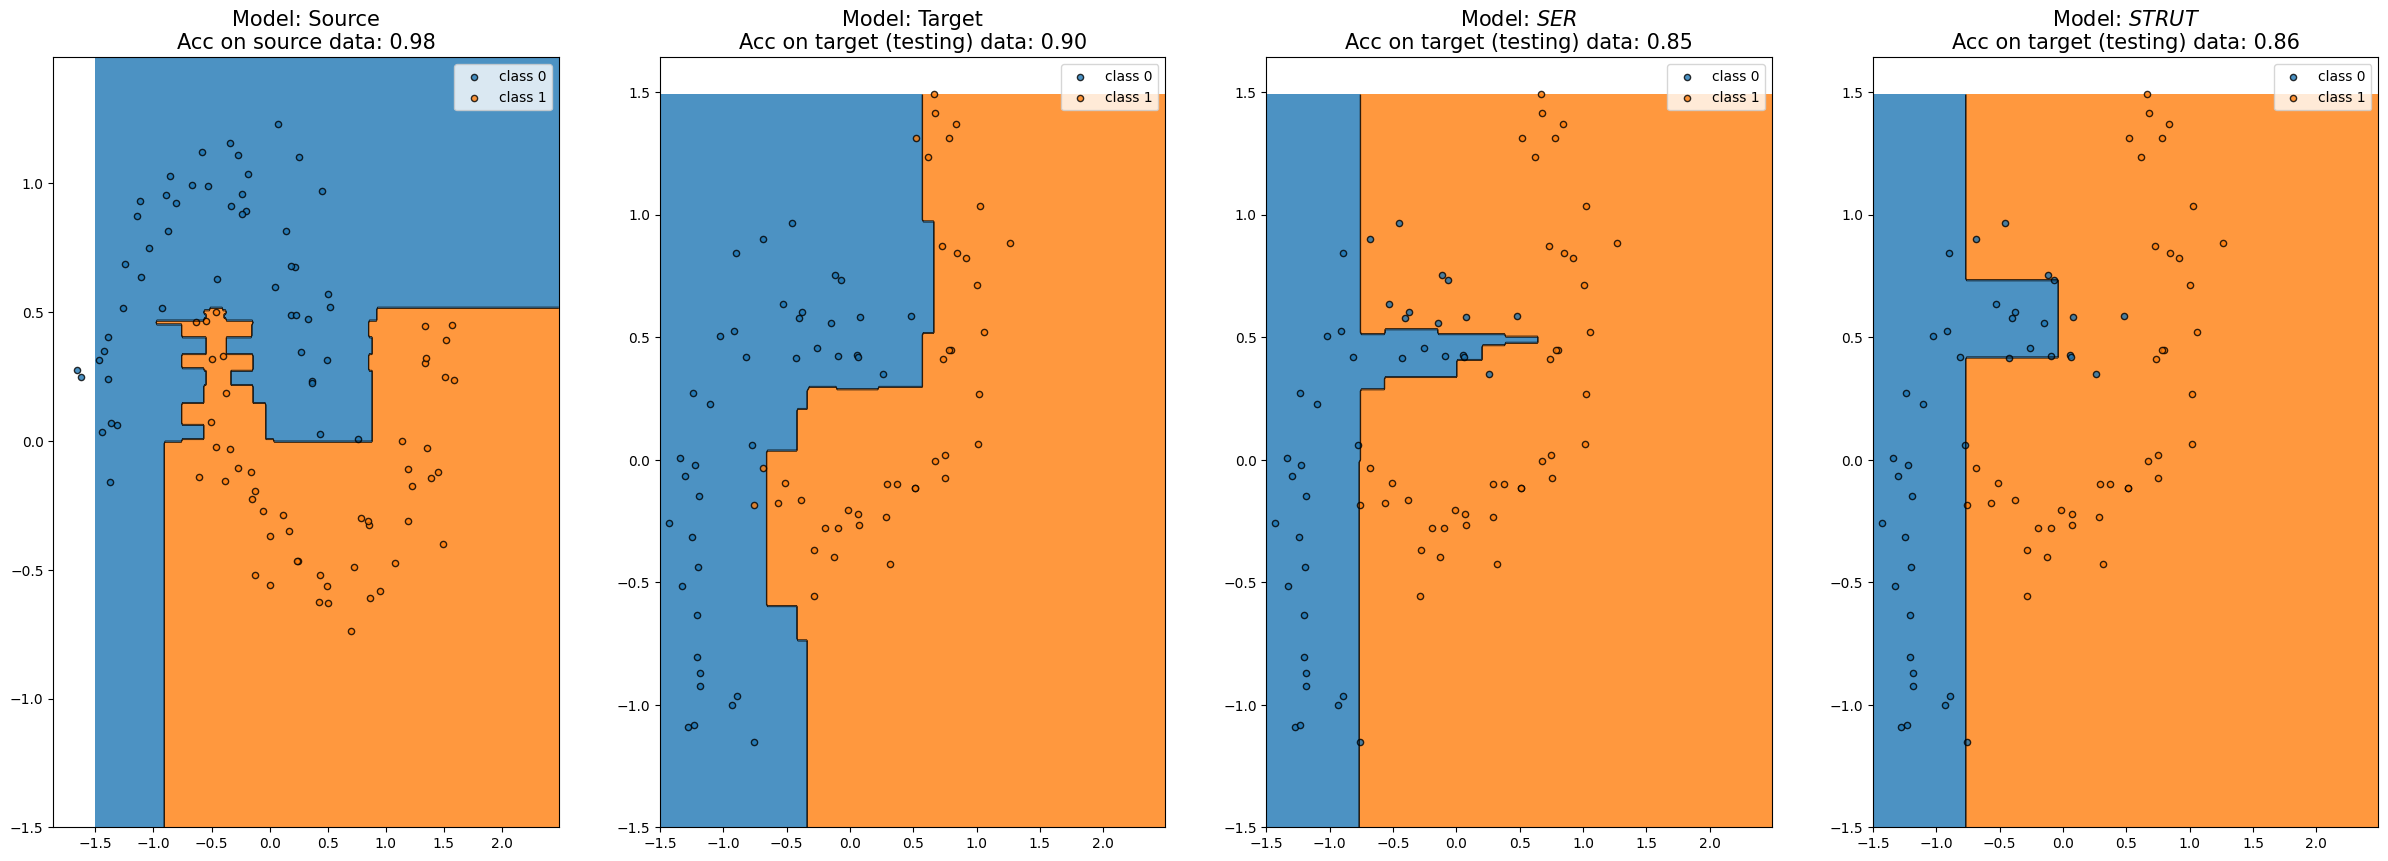

In [45]:
# Plot decision functions

plot_step = 0.01

fig, ax = plt.subplots(nrows=1, ncols=len(methods) + 2, figsize=(30, 10))


plot_dec_func(ax[0], clf_source,  x_min = xlim[0], x_max = xlim[1], y_min = ylim[0], y_max = ylim[1], plot_step = plot_step, title='Source model',nc=1)
plot_dots(ax[0],Xs,ys, title='Source data')
ax[0].set_title('Model: Source\nAcc on source data: {:.2f}'.format(np.mean(score_src)),
                fontsize=15)

plot_dec_func(ax[1], clf_target,  x_min = xlim[0], x_max = xlim[1], y_min = ylim[0], y_max = ylim[1], plot_step = plot_step, title='Target model',nc=1)
plot_dots(ax[1],X_tgt_test,Y_tgt_test, title='Target data')
ax[1].set_title('Model: Target\nAcc on target (testing) data: {:.2f}'.format(np.mean(score_tgt)),
                fontsize=15)


# Plot transfer models
for i, (method, label, score) in enumerate(zip(methods, labels, scores)):
    clf_transfer = clfs[i]

    plot_dec_func(ax[i+2], clf_transfer, x_min = xlim[0], x_max = xlim[1], y_min = ylim[0], y_max = ylim[1], plot_step = plot_step, title=label,nc=1)
    plot_dots(ax[i+2],X_tgt_test,Y_tgt_test, title=label)
    ax[i + 2].set_title('Model: {}\nAcc on target (testing) data: {:.2f}'.format(label, score),
                        fontsize=15)

plt.show()

<h3>Example 3 : random forest for numerous gaussian clusters classification </h3><a name="rf_clust"></a>